### Basic Concepts: Nodes, Edges & State

In [9]:
from dataclasses import dataclass
from typing import TypedDict
from langgraph.graph import END, START, StateGraph

class InputState(TypedDict):
    string_value: str
    numeric_value: int


def modify_state(input: InputState):
    print(f"Current value: {input}")
    print(f"Current type: {type(input)}")
    return input


graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)
graph.add_edge(START, "branch_a")
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b", END)

graph.set_entry_point("branch_a")

runnable = graph.compile()

In [6]:
type(runnable)

langgraph.graph.state.CompiledStateGraph

### Visualize graph

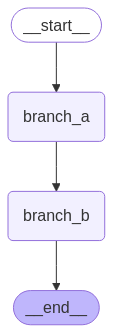

In [7]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        runnable.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [8]:
runnable.invoke({"string_value": "a"})

TypeError: InputState.__init__() missing 1 required positional argument: 'numeric_value'

In [11]:
runnable.invoke({"string_value": "a", "numeric_value": 1})

Current value: {'string_value': 'a', 'numeric_value': 1}
Current type: <class 'dict'>
Current value: {'string_value': 'a', 'numeric_value': 1}
Current type: <class 'dict'>


{'string_value': 'a', 'numeric_value': 1}

In [13]:
def modify_state(input: InputState):
    input["string_value"] += "a"
    input["numeric_value"] += 1
    return input


graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b", END)


graph.set_entry_point("branch_a")

runnable = graph.compile()

In [14]:
try:
    runnable.invoke({"string_value": "a"})
except KeyError as e:
    print(e)

'numeric_value'


In [15]:
runnable.invoke({"string_value": "a", "numeric_value": 1})

{'string_value': 'aaa', 'numeric_value': 3}

### Why not use just LCEL?

In [16]:
from langchain_core.runnables import RunnableLambda

In [17]:
runnable = RunnableLambda(modify_state)

chain = runnable | runnable

In [18]:
chain.invoke({"string_value": "a", "numeric_value": 1})

{'string_value': 'aaa', 'numeric_value': 3}

### Cycles and Conditional Edges

In [ ]:
def modify_state(input: InputState):
    input["string_value"] += "a"
    input["numeric_value"] += 1
    return input


def router(input: InputState):
    if input["numeric_value"] < 5:
        return "branch_a"
    else:
        return "__end__"


graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)
graph.add_edge("branch_a", "branch_b")
graph.add_conditional_edges(
    "branch_b", router, {"branch_a": "branch_a", "__end__": END}
)

graph.set_entry_point("branch_a")

runnable = graph.compile()

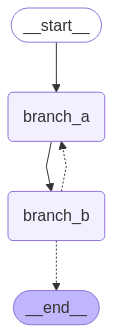

In [20]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        runnable.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [21]:
runnable.invoke({"string_value": "a", "numeric_value": 1})

{'string_value': 'aaaaa', 'numeric_value': 5}

### Reducer functions

In [29]:
from typing import TypedDict, Annotated
from langgraph.graph import END, StateGraph
from operator import add


class InputState(TypedDict):
    no_change_value: str
    string_value: Annotated[str, add]
    numeric_value: Annotated[int, add]
    list_value: Annotated[list[str], add]
    conjunto: Annotated[set[str], set.union]


def modify_state(input: InputState):
    return input

In [30]:
graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b", END)

graph.set_entry_point("branch_a")

runnable = graph.compile()

ValueError: no signature found for builtin <method 'union' of 'set' objects>

In [28]:
runnable.invoke(
    {
        "no_change_value": "a",
        "string_value": "a",
        "numeric_value": 1,
        "list_value": ["a"],
        "conjunto": {"a"},
    }
)

TypeError: unsupported operand type(s) for +: 'set' and 'set'

### Alternative State

In [32]:
from typing import TypedDict
from langgraph.graph import END, StateGraph


class InputState(TypedDict):
    string_value: str
    numeric_value: int


# class InputState(BaseModel):
#       string_value: str
#       numeric_value: int


def modify_state(input: InputState):
    string_value = input["string_value"]
    # string_value = input.string_value
    print(string_value)
    return input


graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b", END)

graph.set_entry_point("branch_a")

runnable = graph.compile()

In [33]:
runnable.invoke({"string_value": "a", "numeric_value": "a"})

a
a


{'string_value': 'a', 'numeric_value': 'a'}